## BERT for Pharmacy Website Text Classification
### Goal: Train model to determine if online pharmacy is accredited or not.
#### Dataset: 
- Accredited Online Pharmacies are labeled 0
- Non-Accredited Online Pharmacies are labeled 1 
- 'Text' column created in this notebook is a combination of body, footer, and header text scraped from each website
- This is a subset of websites. The final dataset will be larger.

### Text Pre-Processing for Feature-Based Training
- BERT (Bidirectional Encoder Representations from Transformers)
- BERT makes use of a Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text
- Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task. 
- Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary
- the Transformer encoder reads the entire sequence of words at once

- Resources: 
    - https://keras.io/examples/nlp/text_extraction_with_bert/#preprocess-the-data
    - https://collab.its.virginia.edu/access/lessonbuilder/item/2079372/group/25e8dc9b-3e66-4249-ae38-3a124dead1e4/Module%207:%20Seque_%2010_12%20-%2010_18/7.5%20%20Video%20+%20Qu_%20and%20Attention/M7.5_%20NLP%20with%20Attention,%20Transformers,%20and%20BERT.pdf
    - https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d#98ee
    - https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
    - https://www.tensorflow.org/text/tutorials/classify_text_with_bert
    - https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d
    - https://towardsdatascience.com/how-to-train-a-bert-model-from-scratch-72cfce554fc6
    - https://huggingface.co/docs/tokenizers/pipeline

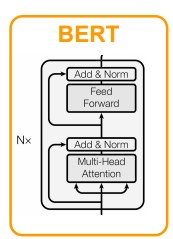

Two-Phase training:

1.) Pretrain to understand language

2.) Finetune to learn a specific task


### Setup

In [1]:
#import libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
import tensorflow_text as text


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

### Load Data

In [2]:
#import data
pharm_data = pd.read_csv('pharmacy_dataset_reduced.csv')
data = pharm_data.copy()
data.head(2)
len(data)

,Website,Body,Header,Footer,Image Urls,Accredited,Complete_html,Zipcode,Valid_phone
0,https://acariahealth.envolvehealth.com,Skip to Main Content Home Contact Insights Sea...,Home Contact Insights Search Search About Over...,Locations Referral Forms Careers Disclaimer HI...,['https://acariahealth.envolvehealth.com/conte...,0,Skip to Main Content Home Contact Insights Sea...,0,1
1,https://alto.com,Shop Alto Essentials to add pharmacy products ...,Shop Alto Essentials to add pharmacy products ...,Our Story Careers Drive for Alto For Providers...,['https://images.prismic.io/alto/176341aa-258d...,0,Shop Alto Essentials to add pharmacy products ...,0,1
2,https://www.amberpharmacy.com,Loading... Skip to navigation Skip to main con...,NaN,About Careers 340B Hospital Program Locations ...,['https://www.amberpharmacy.com/wp-content/the...,0,NaN,0,0
3,https://www.aoncology.com,For Patients Careers Blog Practice Success Pat...,For Patients Careers Blog Practice Success Pat...,"© 2020 American Oncology Network, LLC. All Rig...",['https://dc.ads.linkedin.com/collect/?pid=944...,0,For Patients Careers Blog Practice Success Pat...,1,0
4,https://www.birdirx.com,Loading... × Close alert Fly with Birdi! Free...,NaN,Support Hours of Operation Monday through Frid...,"[""https://www.birdirx.comdata:image/svg+xml;ch...",0,NaN,0,0


### Preprocess & Clean Data

In [3]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [4]:
#combine columns into new column containing all text
data['text'] = data['Body'].astype(str) + data['Header'].astype(str) + data['Footer'].astype(str)
data.head(2)

,Website,Body,Header,Footer,Image Urls,Accredited,Complete_html,Zipcode,Valid_phone,text
0,https://acariahealth.envolvehealth.com,Skip to Main Content Home Contact Insights Sea...,Home Contact Insights Search Search About Over...,Locations Referral Forms Careers Disclaimer HI...,['https://acariahealth.envolvehealth.com/conte...,0,Skip to Main Content Home Contact Insights Sea...,0,1,Skip to Main Content Home Contact Insights Sea...
1,https://alto.com,Shop Alto Essentials to add pharmacy products ...,Shop Alto Essentials to add pharmacy products ...,Our Story Careers Drive for Alto For Providers...,['https://images.prismic.io/alto/176341aa-258d...,0,Shop Alto Essentials to add pharmacy products ...,0,1,Shop Alto Essentials to add pharmacy products ...


In [5]:
#rename Accredited as 'label'
data=data.rename(columns = {'Accredited': 'label'}, inplace = False)
data.head(2)

,Website,Body,Header,Footer,Image Urls,label,Complete_html,Zipcode,Valid_phone,text
0,https://acariahealth.envolvehealth.com,Skip to Main Content Home Contact Insights Sea...,Home Contact Insights Search Search About Over...,Locations Referral Forms Careers Disclaimer HI...,['https://acariahealth.envolvehealth.com/conte...,0,Skip to Main Content Home Contact Insights Sea...,0,1,Skip to Main Content Home Contact Insights Sea...
1,https://alto.com,Shop Alto Essentials to add pharmacy products ...,Shop Alto Essentials to add pharmacy products ...,Our Story Careers Drive for Alto For Providers...,['https://images.prismic.io/alto/176341aa-258d...,0,Shop Alto Essentials to add pharmacy products ...,0,1,Shop Alto Essentials to add pharmacy products ...


In [6]:
#reduce dataset to only the columns we need, 'label' and 'text'
data = data.drop(['Website', 'Body', 'Header', 'Footer', 'Image Urls', 'Complete_html', 'Zipcode', 'Valid_phone'], axis=1)

In [7]:
#Sentences contain the entire text data and labels contain all the corresponding labels
data.head(3)

,label,text
0,0,Skip to Main Content Home Contact Insights Sea...
1,0,Shop Alto Essentials to add pharmacy products ...
2,0,Loading... Skip to navigation Skip to main con...


In [8]:
#drop any missing values
data = data.dropna()

In [9]:
#reset index
data=data.reset_index(drop=True) 
#shuffle data
data = shuffle(data)   
data.head(3)

,label,text
4,0,Loading... × Close alert Fly with Birdi! Free...
62,1,Log In Register Checkout Languages: Currencies...
18,0,Looking to save up to 80% on your medications?...


In [10]:
#apply the function to clean the text - all lower case, strip spaces and characters 
data['text']=data['text'].map(preprocess_sentence)    
data.head(3)

,label,text
4,0,loading close alert fly birdi free shipping or...
62,1,log register checkout languages currencies dol...
18,0,looking save medications find mygeniusrx healt...


### Split Data - Training & Testing

In [11]:
#define the number of unique classes under 'label'
num_classes=len(data.label.unique())
num_classes

2

In [12]:
#define y variable
y = tf.keras.utils.to_categorical(data["label"].values, num_classes=num_classes)
#y

In [13]:
#split data into test and train
x_train, x_test, y_train, y_test = train_test_split(data['text'], y, test_size=0.3)
len(x_train), len(x_test), len(y_train), len(y_test)

(50, 22, 50, 22)

### Data Modeling

#### Load BERT with TensorFlow Hub
- repository of trained machine learning models
- use universal-sentence-encoder-cmlm/multilingual-base = universal sentence encoder (100+ languages)
    - uses conditional masked language model
- Goal: turn text into high-dim vectors that capture sentence-level semantics
    - get embeddings from input text with preprocessor and encoder

In [14]:
#load bert with tensorflow hub
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

#function to get word embeddings
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

#test function
#get_embeddings([
   # "This is a test para ver el futuro of the model."])

In [15]:
## Note: an option in the future is to observe semantic textual similarities

### Create & Train Classification Model
- Observe different metrics during training: Precision, Recall, F1 Score

In [16]:
#resource: https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d#98ee
from keras import backend as K

#functions to find recall
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

#functions to find precision
def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

#functions to find f1 score
def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

#### Define Model
- preporcessor & encoder layers
- dropout & dense layer with softmax activation function
- output space dimension = # of classes 

In [17]:
#define model
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

#### Compile & Fit Model

In [18]:
#define number of epochs
n_epochs = 50

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

#EarlyStopping callback to monitor validation loss
#if metric doesn't improve for at least 3 epochs (patience = 3)
    #training is interrupted and weights from epoch where the validation loss 
    #showed the best value (i.e. lowest) are restored (restore_best_weights = True)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)
#compile model
model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)
#fit model
model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback], verbose=1)

Epoch 1/50
2/2 [==============================] - 19s 6s/step - loss: 0.7415 - accuracy: 0.5000 - balanced_recall: 0.5437 - balanced_precision: 0.5469 - balanced_f1_score: 0.5453 - val_loss: 0.6204 - val_accuracy: 0.6818 - val_balanced_recall: 0.6250 - val_balanced_precision: 0.6143 - val_balanced_f1_score: 0.6196
Epoch 2/50
2/2 [==============================] - 7s 4s/step - loss: 0.6324 - accuracy: 0.6200 - balanced_recall: 0.6375 - balanced_precision: 0.6468 - balanced_f1_score: 0.6421 - val_loss: 0.5736 - val_accuracy: 0.7727 - val_balanced_recall: 0.6354 - val_balanced_precision: 0.7281 - val_balanced_f1_score: 0.6786
Epoch 3/50
2/2 [==============================] - 7s 4s/step - loss: 0.6417 - accuracy: 0.6600 - balanced_recall: 0.6562 - balanced_precision: 0.7500 - balanced_f1_score: 0.6993 - val_loss: 0.5501 - val_accuracy: 0.8182 - val_balanced_recall: 0.7188 - val_balanced_precision: 0.7917 - val_balanced_f1_score: 0.7534
Epoch 4/50
2/2 [==============================] - 7s 4

### Plot Results

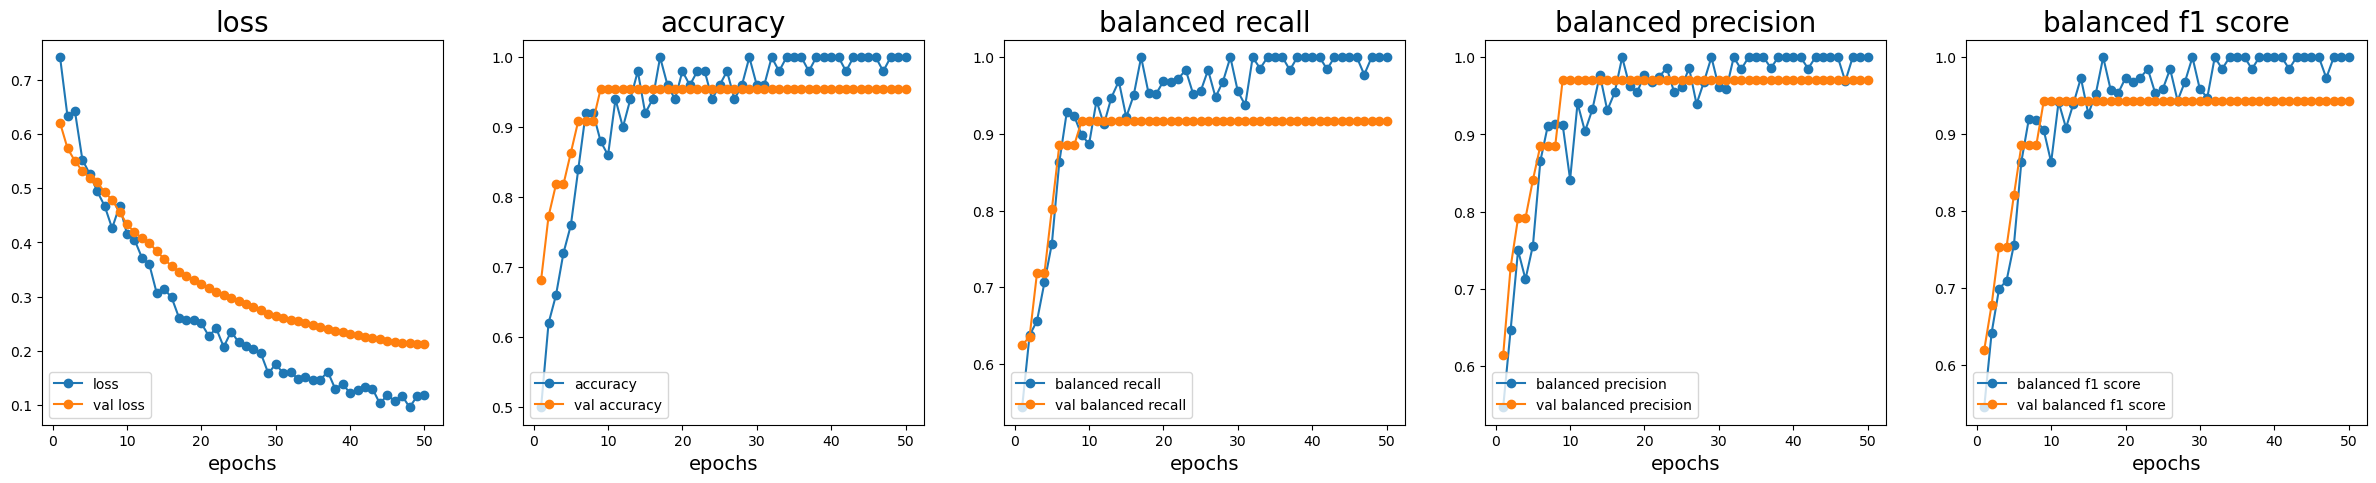

In [19]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

### Next Steps: 
- Add address/phone number variables
- Combine with image model in Functional API
- Make Predictions 